Figure for comparing vis & motor

session 0
hidden states:  vis:3 motor 3

- firing rate in both vis & motor   Peng
- decoder using firing rates of both vis & motor to predict trial types (vis_stimuli & response)  Jing
- best num of hidden states in both vis & motor   Peng
- hidden states matrix, state sequencce, posterior prob, transition matrix  Peng
- statistical features in both vis & motor under different trial types  Yuyang
- connect hidden states with its actual meaning (stimuli direction in vis  Farnaz, move_direcction in motor  Ula)
- decoder using hidden states of both vis & motor to predict trial types (vis_stimuli & response)  Yidan, Jing
- (other areas) Ula

In [2]:
import ssm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [4]:
regions = ["vis ctx", "motor ctx", "other areas"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                [ "MOp", "MOs"],  # motor cortex
                ]

nareas = 2  # only consider vis ctx and motor ctx

# find good sessions, where vis_ctx neurons > 100 and motor_ctx neurons > 100
vis_neurons = np.zeros(len(alldat))
motor_neurons = np.zeros(len(alldat))

for i in range(len(alldat)):
    dat = alldat[i]   # a dict
    NN = len(dat['brain_area'])  # number of neurons 
    barea = nareas * np.ones(NN, )  # last one is "other" 
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign 0 to vis_ctx, 1 to motor_ctx

    areas, neurons = np.unique(barea, return_counts=True)

    if np.isin(0, areas):
        vis_neurons[i] = neurons[0]
        if np.isin(1, areas):   
            motor_neurons[i] = neurons[1]
    else:
        if np.isin(1, areas):   
            motor_neurons[i] = neurons[0]    
# print(f'vis_neurons:{vis_neurons}')
# print(f'motor_neurons:{motor_neurons}')

vis_motor_pair = np.vstack((vis_neurons, motor_neurons)).T
good_vis_motor_pair_id = np.argwhere(np.logical_and(vis_motor_pair[:, 0]>100, vis_motor_pair[:, 1]>100)).flatten()
print(good_vis_motor_pair_id)
good_vis_motor_pair = vis_motor_pair[good_vis_motor_pair_id]
print(good_vis_motor_pair)

[ 0  7 25]
[[178. 113.]
 [111. 112.]
 [162. 166.]]


Select a session contain many neurons from both vis_ctx and motor_ctx

In [63]:
dat = alldat[7]   # a dict
NN = len(dat['brain_area'])  # number of neurons 
barea = nareas * np.ones(NN, )  # last one is "other" 
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign 0 to vis_ctx, 1 to motor_ctx

vis_neurons_id = np.argwhere(barea==0).flatten()
motor_neurons_id = np.argwhere(barea==1).flatten()

print(len(vis_neurons_id))
print(len(motor_neurons_id))

111
112


In [64]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']
print(f'neural_activity:{neural_activity.shape}')

vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left
response = dat['response']  # right - nogo - left (-1, 0, 1)

# trials types by visual stimuli
vis_left_id = vis_stim > 0
vis_no_id = vis_stim == 0
vis_right_id = vis_stim < 0

# trials types by response
resp_left_id = response > 0
resp_no_id = response == 0
resp_right_id = response < 0

# trials types by result
correct_id_left = np.logical_and(vis_left_id, resp_left_id)
correct_id_no = np.logical_and(vis_no_id, resp_no_id)
correct_id_right = np.logical_and(vis_right_id, resp_right_id)
correct_id = np.logical_or(correct_id_left, correct_id_no)
correct_id = np.logical_or(correct_id, correct_id_right)
incorrect_id = np.logical_not(correct_id)

neural_activity:(1156, 250, 250)


plot firing rate in vis_ctx & motor ctx

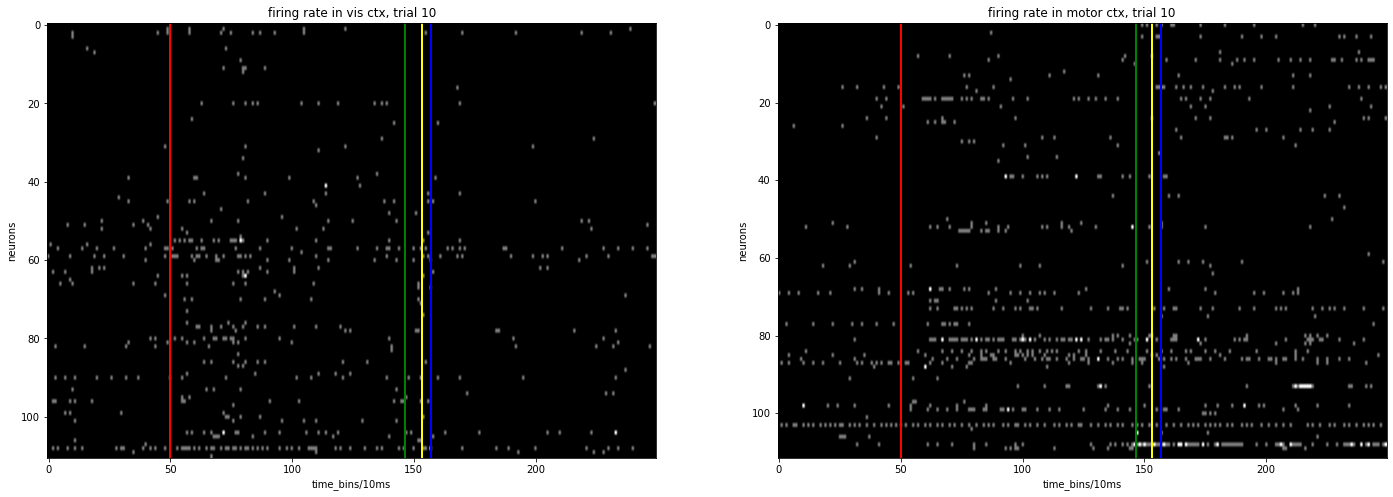

In [85]:
n_trial = 10
fig, axes = plt.subplots(ncols=2, figsize=(24, 8))

for i in range(nareas):

    neural_activity_area = neural_activity[barea==i]
    axes[i].imshow(neural_activity_area[:,n_trial,:], aspect='auto', cmap='gray')
    axes[i].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[i].axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    axes[i].axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    axes[i].axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    axes[i].set_ylabel("neurons")
    axes[i].set_xlabel("time_bins/10ms")
    axes[i].set_title(f'firing rate in {regions[i]}, trial {n_trial}')

plt.show()

decoder using firing rate from vis_ctx & motor_ctx

best num of hidden states in vis_ctx & motor_ctx

In [86]:
def Possion_HMM(input_data, num_states, num_features):

    p_hmm = ssm.HMM(num_states, num_features, observations="poisson")
    p_hmm.fit(input_data, method="em", num_iters = 100)
    hidden_states = p_hmm.most_likely_states(input_data)       # time_bins
    transition_matrix = p_hmm.transitions.transition_matrix    # num_states x num_states
    posterior_prob, _, _ = p_hmm.expected_states(input_data)   # posterior_prob: time_bins x num_states
    log_like = p_hmm.log_probability(input_data)

    return hidden_states, posterior_prob, transition_matrix, log_like

In [87]:
num_states = 3
hidden_states_areas = {}
posterior_prob_areas = {}
transition_matrix_areas = {}

for i in range(nareas):

    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]
    input_data = input_data.reshape(num_neurons, num_trials*num_bins)

    hidden_states, posterior_prob, transition_matrix, _ = Possion_HMM(input_data.T, num_states, num_neurons)

    hidden_states_areas[i] = hidden_states
    posterior_prob_areas[i] = posterior_prob
    transition_matrix_areas[i] = transition_matrix

LP: -614972.3: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


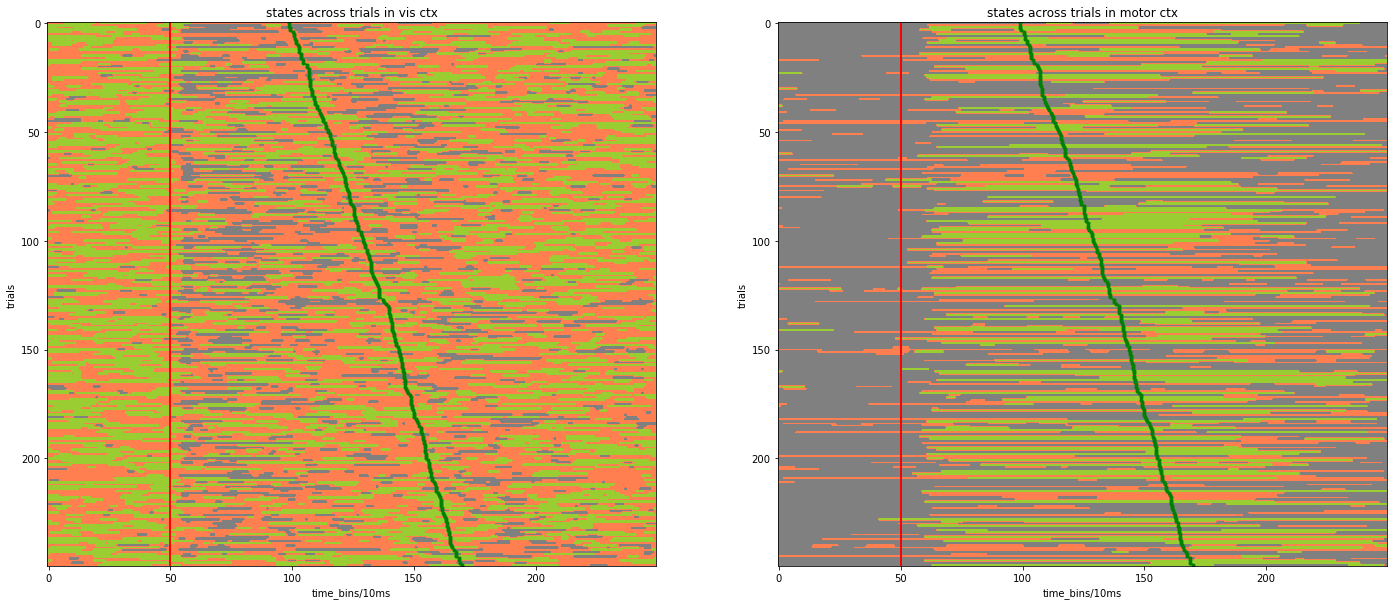

In [88]:
f, axes = plt.subplots(ncols=nareas, figsize=(24, 10))

for i in range(nareas):

    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]

    states_mat = hidden_states_areas[i].reshape(num_trials, num_bins)
    go_cue_array = gocue/bin_size
    go_cue_array = go_cue_array.flatten()
    go_cue_idx = np.argsort(go_cue_array)

    go_cue_sorted = go_cue_array[go_cue_idx]
    states_mat_sorted = states_mat[go_cue_idx, :]

    cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
    axes[i].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
    axes[i].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[i].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
    axes[i].set_ylabel("trials")
    axes[i].set_xlabel("time_bins/10ms")
    axes[i].set_title(f'states across trials in {regions[i]}')

plt.tight_layout
plt.show()

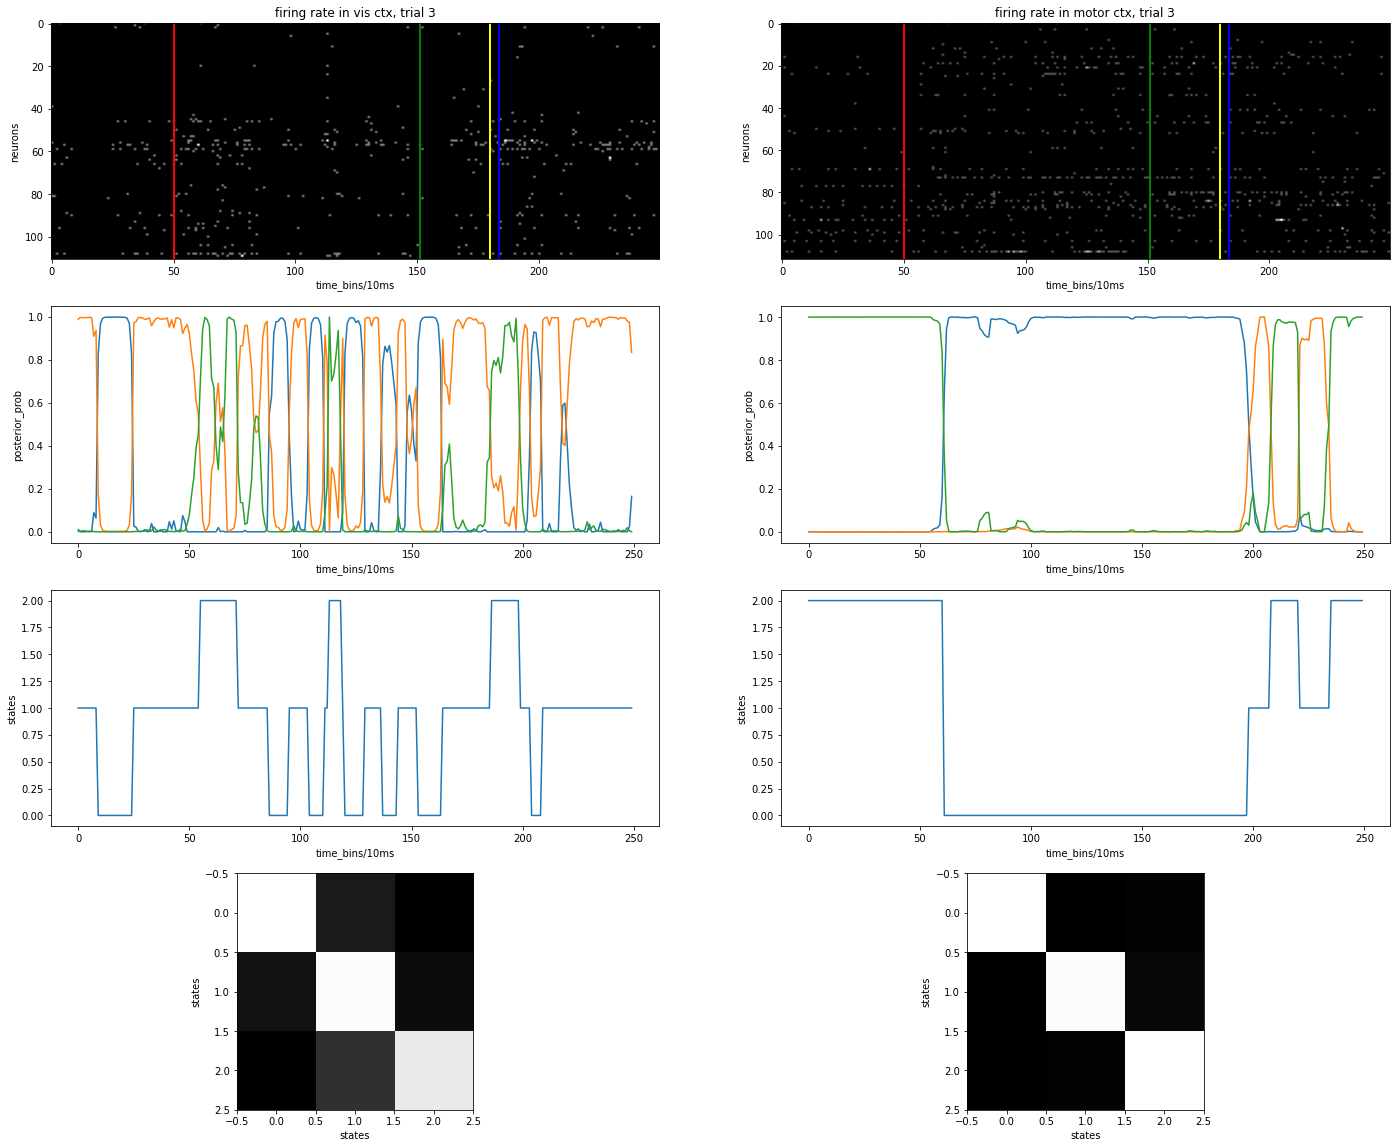

In [89]:
n_trial = 3
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24,20))

for i in range(nareas):

    neural_activity_area = neural_activity[barea==i]
    axes[0][i].imshow(neural_activity_area[:,n_trial,:], aspect='auto', cmap='gray')
    axes[0][i].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
    axes[0][i].axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
    axes[0][i].axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
    axes[0][i].axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
    axes[0][i].set_ylabel("neurons")
    axes[0][i].set_xlabel("time_bins/10ms")
    axes[0][i].set_title(f'firing rate in {regions[i]}, trial {n_trial}')
    
    num_neurons = neural_activity_area.shape[0]
    num_trials = neural_activity_area.shape[1]
    num_bins = neural_activity_area.shape[2]
    states_mat = hidden_states_areas[i].reshape(num_trials, num_bins)
    posterior_prob_mat = posterior_prob_areas[i].reshape(num_trials, num_bins, num_states)

    axes[1][i].plot(posterior_prob_mat[n_trial])
    axes[1][i].set_ylabel("posterior_prob")
    axes[1][i].set_xlabel("time_bins/10ms")

    axes[2][i].plot(states_mat[n_trial])
    axes[2][i].set_ylabel("states")
    axes[2][i].set_xlabel("time_bins/10ms")

    axes[3][i].imshow(transition_matrix_areas[i], cmap='gray')
    axes[3][i].set_ylabel("states")
    axes[3][i].set_xlabel("states")

plt.show()

In [100]:
n_folds = 5
max_states = 8
kf = KFold(n_splits=n_folds, shuffle=True, random_state=None)

ll_training = np.zeros((nareas, max_states, n_folds))
ll_testing = np.zeros((nareas, max_states, n_folds))
BIC_testing = np.zeros((nareas, max_states, n_folds))

hmm_z_ms = np.zeros((nareas, max_states, num_trials*num_bins))

for i in range(nareas):

    input_data = neural_activity[barea==i]
    num_neurons = input_data.shape[0]
    num_trials = input_data.shape[1]
    num_bins = input_data.shape[2]
    input_data = input_data.reshape(num_neurons, num_trials*num_bins)
    input_data = input_data.T

    for j, num_states in enumerate(range(1, max_states+1)):
        #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
        num_para = num_states*num_states + num_states*num_neurons + num_states*num_neurons

        for k, (train_index, test_index) in enumerate(kf.split(input_data)):
            print(f"kfold {k} TRAIN:", len(train_index), "TEST:", len(test_index))

            n_train = len(train_index)
            n_test = len(test_index)
            
            #Split data
            train_data = input_data[train_index]
            test_data = input_data[test_index]

            p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
            p_hmm.fit(train_data, method="em", num_iters=100)
            ll_training[i, j, k] = p_hmm.log_probability(train_data)/n_train
            ll_testing[i, j, k] = p_hmm.log_probability(test_data)/n_test
            
            #calculate the BIC
            BIC_testing[i, j, k] = num_para*np.log(n_test) - 2*p_hmm.log_probability(test_data)
            
        # #Let's do a full model fit and get the state-sequence
        # p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
        # p_hmm.fit(input_data, method="em", num_iters=100)
        # most_likely_states = p_hmm.most_likely_states(input_data)
        # hmm_z_ms[j,:] = p_hmm.most_likely_states(input_data)

kfold 0 TRAIN: 50000 TEST: 12500


LP: -363116.4: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -361754.7: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -361796.4: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -362965.8: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -361358.8: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -344346.1: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -343485.4: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -343331.0: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -343693.1: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -344198.4: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -338230.1: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -338266.5: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -339389.1: 100%|██████████| 100/100 [08:53<00:00,  5.33s/it] 


kfold 2 TRAIN: 50000 TEST: 12500


LP: -339622.6: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -337920.0: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -336043.4: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -336555.7: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -336748.0: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -338086.9: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -335783.6: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -336448.8: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -335606.1: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -335067.1: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -335018.5: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -336111.5: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -334627.5: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -334366.4: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -334319.4: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -335601.4: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -335253.4: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -334093.1: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -334036.7: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -332398.2: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -335244.5: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -333896.4: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -333158.8: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -333629.5: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -333739.7: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -332606.1: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -332166.9: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -513323.6: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -513811.9: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -512808.6: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -514365.2: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


kfold 0 TRAIN: 50000 TEST: 12500


LP: -512022.3: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -497743.5: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -497996.6: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -498905.7: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -498607.8: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


kfold 1 TRAIN: 50000 TEST: 12500


LP: -498120.6: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -492807.0: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -492848.4: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -491789.3: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -493930.3: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


kfold 2 TRAIN: 50000 TEST: 12500


LP: -492042.8: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -486945.8: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -487039.3: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -488869.7: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -487335.2: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


kfold 3 TRAIN: 50000 TEST: 12500


LP: -487270.3: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -483729.9: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -485656.0: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -484478.4: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -484645.4: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


kfold 4 TRAIN: 50000 TEST: 12500


LP: -483710.1: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -483435.0: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -480860.9: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -482543.5: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -482105.2: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


kfold 5 TRAIN: 50000 TEST: 12500


LP: -482416.9: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -479962.9: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -481419.8: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -481250.2: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -480401.8: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


kfold 6 TRAIN: 50000 TEST: 12500


LP: -480229.6: 100%|██████████| 100/100 [01:14<00:00,  1.33it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -479146.9: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -479601.3: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -479852.5: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -479332.4: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


kfold 7 TRAIN: 50000 TEST: 12500


LP: -479396.1: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


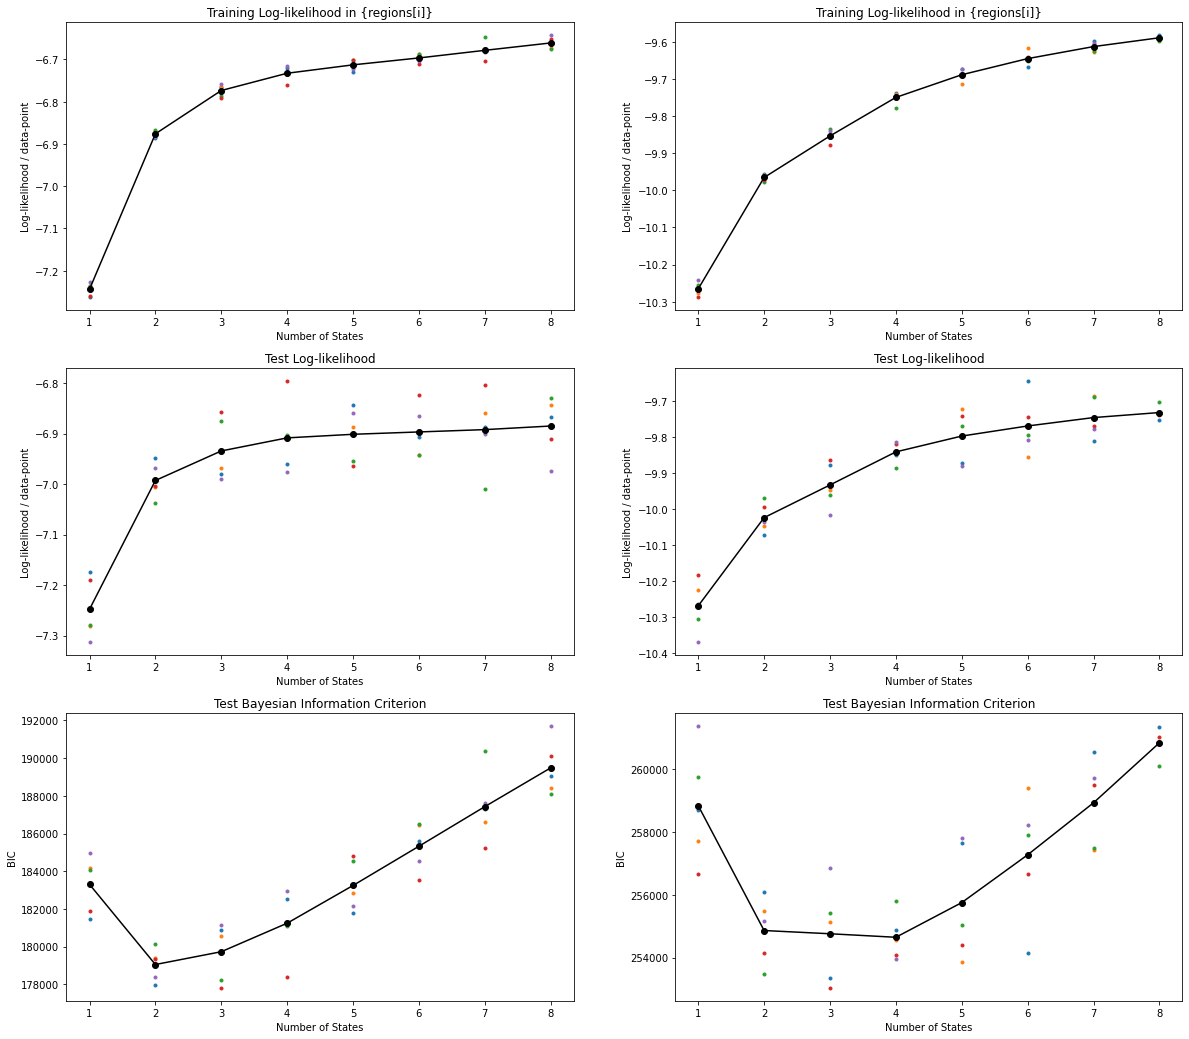

In [101]:
##===== plot the heldout and training log-likelihoods and compare =====##

fig, axes = plt.subplots(3, 2, figsize=(20,18))

for i in range(nareas):

    #Training data
    axes[0][i].plot(np.arange(1, max_states+1), ll_training[i], '.')
    axes[0][i].plot(np.arange(1, max_states+1), np.mean(ll_training[i], axis=1),'-ok')
    axes[0][i].set_title('Training Log-likelihood in {regions[i]}')
    axes[0][i].set_ylabel('Log-likelihood / data-point')
    axes[0][i].set_xticks(np.arange(1, max_states+1))
    axes[0][i].set_xlabel('Number of States')

    axes[1][i].plot(np.arange(1, max_states+1), ll_testing[i], '.')
    axes[1][i].plot(np.arange(1, max_states+1), np.mean(ll_testing[i], axis=1), '-ok')
    axes[1][i].set_title('Test Log-likelihood')
    axes[1][i].set_ylabel('Log-likelihood / data-point')
    axes[1][i].set_xticks(np.arange(1, max_states+1))
    axes[1][i].set_xlabel('Number of States')

    axes[2][i].plot(np.arange(1, max_states+1), BIC_testing[i], '.')
    axes[2][i].plot(np.arange(1, max_states+1), np.mean(BIC_testing[i], axis=1), '-ok')
    axes[2][i].set_title('Test Bayesian Information Criterion')
    axes[2][i].set_ylabel('BIC')
    axes[2][i].set_xticks(np.arange(1, max_states+1))
    axes[2][i].set_xlabel('Number of States')

plt.show()
